In [1]:
# Import required libraries and load the raw Bitcoin dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("bit.csv")  

df.head()


,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [2]:
# Prepare and format the dataset by renaming columns, converting timestamps, and setting a datetime index for time series analysis

df.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']

df['Timestamp'] = df['Timestamp'].astype(int)

df['timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

df.set_index('timestamp', inplace=True)

df.drop(columns='Timestamp', inplace=True)

df.head()


,Open,High,Low,Close,Volume
timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


In [3]:
# Remove duplicate timestamps to ensure each time point is unique for accurate resampling

df = df[~df.index.duplicated(keep='last')]


In [4]:
# Resample the minute-level data to daily frequency using appropriate OHLC and volume aggregations

daily = df.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})


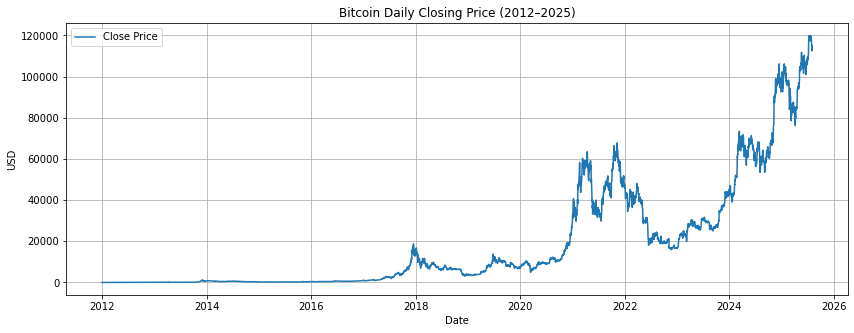

In [5]:
# Plot the daily closing price of Bitcoin over time to visualize long-term market trends

plt.figure(figsize=(14,5))
plt.plot(daily['Close'], label='Close Price')
plt.title("Bitcoin Daily Closing Price (2012–2025)")
plt.xlabel("Date")
plt.ylabel("USD")
plt.grid(True)
plt.legend()
plt.show()


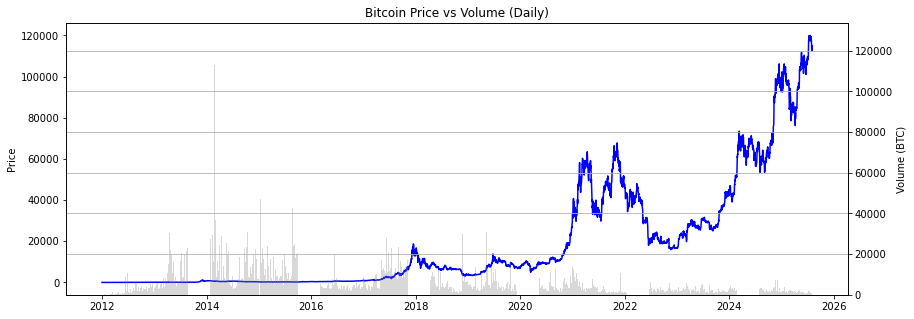

In [6]:
# Create a dual-axis plot to compare Bitcoin's daily closing price with trading volume over time

fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(daily['Close'], color='blue', label='Close Price')
ax2 = ax1.twinx()
ax2.bar(daily.index, daily['Volume'], color='gray', alpha=0.3, label='Volume')


ax1.set_title("Bitcoin Price vs Volume (Daily)")
ax1.set_ylabel("Price")
ax2.set_ylabel("Volume (BTC)")
plt.grid(True)
plt.show()


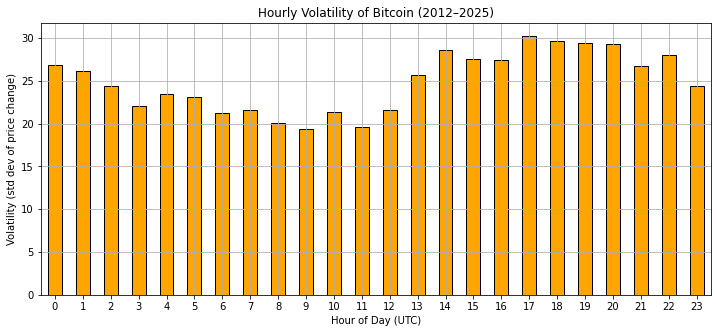

In [7]:
# Analyze Bitcoin's intraday behavior by calculating and visualizing price volatility for each hour of the day

df['price_change'] = df['Close'] - df['Open']

df['hour'] = df.index.hour

volatility_by_hour = df.groupby('hour')['price_change'].std()

plt.figure(figsize=(12,5))
volatility_by_hour.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Hourly Volatility of Bitcoin (2012–2025)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Volatility (std dev of price change)")
plt.grid(True)
plt.xticks(rotation=0)
plt.show()


In [8]:
# Recompute daily aggregates from minute-level data to prepare for further daily-level analysis

daily = df.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})


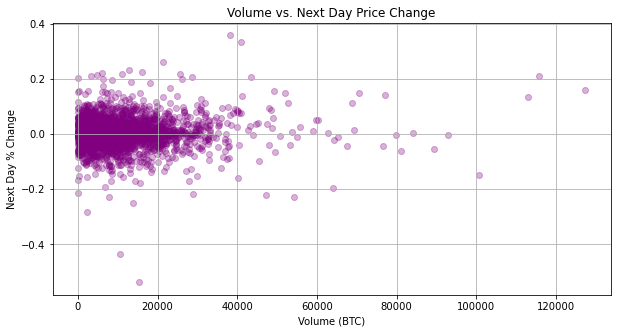

Correlation between volume and next day return: 0.0675


In [9]:
# Explore the relationship between trading volume and next-day price movement by plotting and calculating their correlation

daily_copy = daily.copy()

daily_copy['next_day_return'] = daily_copy['Close'].pct_change().shift(-1)

daily_copy.dropna(inplace=True)

plt.figure(figsize=(10,5))
plt.scatter(daily_copy['Volume'], daily_copy['next_day_return'], alpha=0.3, color='purple')
plt.title("Volume vs. Next Day Price Change")
plt.xlabel("Volume (BTC)")
plt.ylabel("Next Day % Change")
plt.grid(True)
plt.show()

correlation = daily_copy[['Volume', 'next_day_return']].corr().iloc[0,1]
print(f"Correlation between volume and next day return: {correlation:.4f}")


In [11]:
# Identify the top 5 weekly gains and losses by calculating and ranking weekly percentage returns from closing prices

weekly = df['Close'].resample('W').last()

weekly_return = weekly.pct_change()

weekly_df = pd.DataFrame({
    'Close': weekly,
    'weekly_return': weekly_return
})

top_gains = weekly_df.sort_values('weekly_return', ascending=False).head(5)

top_losses = weekly_df.sort_values('weekly_return').head(5)

print("📈 Top 5 Weekly Gains")
print(top_gains[['weekly_return']])

print("\n📉 Top 5 Weekly Losses")
print(top_losses[['weekly_return']])


📈 Top 5 Weekly Gains
            weekly_return
timestamp                
2013-11-24       0.772362
2013-04-07       0.682398
2013-11-17       0.547416
2013-03-24       0.503504
2017-07-23       0.480075

📉 Top 5 Weekly Losses
            weekly_return
timestamp                
2013-04-14      -0.399798
2020-03-15      -0.359101
2018-11-25      -0.336519
2017-12-24      -0.305719
2018-02-04      -0.284340


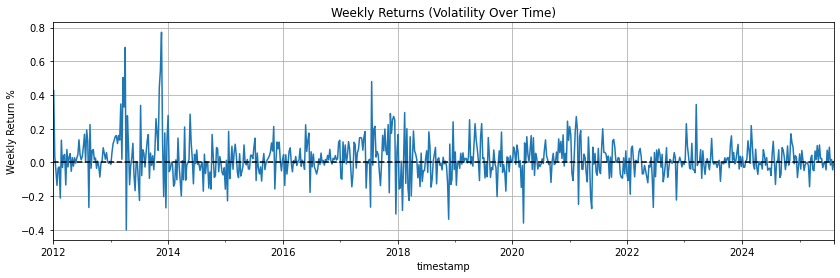

In [12]:
# Visualize weekly return fluctuations over time to highlight periods of high volatility and market shifts

weekly_df['weekly_return'].plot(kind='line', figsize=(14,4), title='Weekly Returns (Volatility Over Time)')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel("Weekly Return %")
plt.grid(True)
plt.show()
